Copyright (c) 2014-2019 National Technology and Engineering
Solutions of Sandia, LLC. Under the terms of Contract DE-NA0003525
with National Technology and Engineering Solutions of Sandia, LLC,
the U.S. Government retains certain rights in this software.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions
are met:

1. Redistributions of source code must retain the above copyright
   notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright
   notice, this list of conditions and the following disclaimer in the
   documentation and/or other materials provided with the distribution.
  
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
"AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



# Trajectory Clustering Example

This notebook is an end-to-end example of how to cluster trajectories in Tracktable using distance geometry.  It goes through the following steps:

1.  Read in points from a file.
2.  Assemble those points into trajectories.
3.  Create a distance geometry signature for each trajectory.
4.  Using those signatures as feature vectors, compute clusters using DBSCAN.
5.  Print statistics about each cluster.
6.  Render the resulting clusters onto a map.

Eventually, distance geometry computation will move into the library itself.

In [1]:
# Set up Matplotlib to render in a notebook before anyone else can change its back end.
import matplotlib
%matplotlib inline

In [2]:
from tracktable.domain.feature_vectors import convert_to_feature_vector
from tracktable.core.geomath import point_at_fraction
from tracktable.core.geomath import distance

def distance_geometry_signature(trajectory, 
                                num_control_points=4,
                                normalize_largest_distance=True):
    """Compute an N-point distance geometry signature
    
    Distance geometry is a technique for characterizing a 
    curve in space by measuring the distances between evenly
    spaced points (which we call control points) on the curve.
    This implementation has two parameters: the number of 
    control points and whether to normalize the distances in
    the signature so that the largest distance is always 1.
    
    The number of control points controls the fidelity of the
    resulting signature.  The more control points, the more 
    accurately the features of the curve can be represented,
    but the longer it takes to compute.  
    
    Normalizing the distances allows shape-based comparison 
    between trajectories by taking the dot product of their
    respective distance geometry signatures.  The higher the
    dot product, the more similar the trajectories.  There are
    many possible normalization schemes; this is one we find 
    useful.
    
    Args:
        trajectory (tracktable.domain.<domain>.Trajectory): 
            Trajectory whose signature you want
        num_control_points (integer, default 4): How many 
            points to sample along the trajectory
        normalize_largest_distance (boolean, default True): 
            Whether or not to normalize
        
    Returns:
        tracktable.domain.feature_vectors.FeatureVectorNN where NN is the size of the resulting
           distance geometry signature
    """
    
    control_point_increment = 1.0 / (num_control_points - 1)
    control_point_fractions = [ control_point_increment * i 
                                for i in range(num_control_points) ]
    
    control_points = [ point_at_fraction(trajectory, t) 
                       for t in control_point_fractions ]
    
    # To create the distance geometry signature, first we measure
    # the distance between the first and last control points;
    # then point 0 and point N-1, then point 1 and N; and so on
    # with successively smaller portions of the curve until at last
    # we are measuring the distances between adjacent points.
    
    signature = []
    for stepsize in range(num_control_points-1, 0, -1):
        for start in range(0, num_control_points - stepsize):
            end = start + stepsize
 #           print("DEBUG: Adding distance between points {} and {}".format(start, end))
            signature.append(distance(control_points[start],
                                      control_points[end]))
    
    if normalize_largest_distance:
        largest_distance = max(signature)
        signature = [ d / largest_distance for d in signature ]
#    print("DEBUG: Signature from {} control points has {} elements".format(num_control_points,
#                                                                           len(signature)))
    return convert_to_feature_vector(signature)
            

In [3]:
from tracktable.examples.example_point_reader import configure_point_reader
from tracktable.examples.example_trajectory_builder import configure_trajectory_builder
from tracktable.script_helpers import argument_groups
from tracktable.script_helpers import argparse
from tracktable import domain
import importlib

def load_trajectories(infile,
                      trajectory_domain='terrestrial',
                      separation_distance=100,
                      separation_time=20,
                      minimum_num_points=5,
                      delimiter=',',
                      object_id_column=0,
                      timestamp_column=1,
                      longitude_column=2,
                      latitude_column=3):
    """Load points from a file and convert them to trajectories.
    
    Args:
       infile (file-like object): Source for points
       trajectory_domain (str, default 'terrestrial'): Name of point domain
          (must be 'terrestrial', 'cartesian2d' or 'cartesian3d')
       point_reader_config (dict, default empty): Parameters for the
          point reader, including columns where the coordinates, ID and
          timestamp are found.  See tracktable.examples.example_point_reader
          for details.
       separation_distance(float, default 100): Maximum distance between
          two points in a single trajectory, measured in kilometers
       separation_time (float, default 20): Maximum number of minutes
          between two adjacent points in a single trajectory
       minimum_num_points (int, default 5): Trajectories with fewer
          than this many points will be discarded
    
       You may also specify any of the following keyword arguments to be 
       passed to the point reader:
    
       delimiter (character, default ','): Delimiter for column in point file
       object_id_column (int, default 0): Which column in the point file contains the object ID
       timestamp_column (int, default 1): Which column in the point file contains the timestamp
       longitude_column (int, default 2): Which column in the point file contains longitude
       latitude_column (int, default 3): Which column in the point file contains latitude
       
    Returns:
       Iterable of trajectories.  You will probably want to put this 
       into a list.
    """

    domain_module = importlib.import_module('tracktable.domain.{}'.format(trajectory_domain))
    reader_type = domain_module.TrajectoryPointReader
    reader = reader_type()
    
    reader.input = infile
    reader.object_id_column = object_id_column
    reader.timestamp_column = timestamp_column
    reader.longitude_column = longitude_column
    reader.latitude_column = latitude_column
    reader.delimiter = delimiter
    
   
    trajectory_builder = configure_trajectory_builder(separation_distance=separation_distance,
                                                      separation_time=separation_time,
                                                      minimum_length=minimum_num_points)
    trajectory_builder.input = reader
    return trajectory_builder 

## Cluster Label Computation

This next section is where the clustering algorithm actually runs.

In [4]:
import os.path
from tracktable.analysis.dbscan import compute_cluster_labels

# You can set your own point source here
point_filename = os.path.expanduser("~/projects/tracktable/data/april_04_2013_first_1m.csv")

# Set any parameters you want on the trajectory builder here
with open(point_filename, 'r') as infile:
    all_trajectories = list(load_trajectories(infile))
    
num_control_points = 4
feature_vectors = [ distance_geometry_signature(trajectory,
                                                num_control_points=num_control_points)
                    for trajectory in all_trajectories
                  ]

# DBSCAN needs two parameters.  The first is the size of the 
# box that defines when two points are close enough to one another
# to belong to the same cluster.  The second is the minimum number
# of points in a cluster.
signature_length = len(feature_vectors[0])

# This is a default search box size.  You can certainly do better.
# You know your data better than we do.
search_box_half_span = [0.01] * signature_length
minimum_cluster_size = 5

cluster_labels = compute_cluster_labels(feature_vectors,
                                        search_box_half_span,
                                        minimum_cluster_size) 


INFO: Trajectory assembly: New trajectories will be declared after a separation of 100.0 units or 0:20:00 seconds.
INFO: Trajectories with fewer than 5 points will be rejected.
(1) STATUS: 100 trajectories announced and 5 discarded for having fewer than 5 points
(1) STATUS: 200 trajectories announced and 7 discarded for having fewer than 5 points
(1) STATUS: 300 trajectories announced and 8 discarded for having fewer than 5 points
(1) STATUS: 400 trajectories announced and 12 discarded for having fewer than 5 points
(1) STATUS: 500 trajectories announced and 15 discarded for having fewer than 5 points
(1) STATUS: 600 trajectories announced and 21 discarded for having fewer than 5 points
(1) STATUS: 700 trajectories announced and 22 discarded for having fewer than 5 points
STATUS: 800 trajectories announced and 24 discarded for having fewer than 5 points
STATUS: 900 trajectories announced and 25 discarded for having fewer than 5 points
STATUS: 1000 trajectories announced and 26 discarde

Testing for point decoration.  First point: (1, 0.569981, 0.814227, 0.202716, 0.379407, 0.435123)
DEBUG: Points are not decorated.


## Cluster Statistics

In [5]:
# Assemble each cluster as a list of its component trajectories.
clusters = {}
for (vertex_id, cluster_id) in cluster_labels:
    if cluster_id not in clusters:
        clusters[cluster_id] = [all_trajectories[vertex_id]]
    else:
        clusters[cluster_id].append(all_trajectories[vertex_id])

def cluster_name(cid):
    if cid == 0:
        return 'Outliers'
    else:
        return 'Cluster {}'.format(cid)
    
print("RESULT: Cluster sizes:")
for (cid, cluster) in clusters.items():
    print("{}: {}".format(cluster_name(cid),
                          len(cluster)))


RESULT: Cluster sizes:
Cluster 1: 8254
Outliers: 1594
Cluster 2: 8
Cluster 3: 6
Cluster 4: 25
Cluster 10: 5
Cluster 5: 9
Cluster 6: 6
Cluster 11: 5
Cluster 7: 5
Cluster 8: 5
Cluster 9: 3


## Cluster Visualization

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x121dc5bf8> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x121dc5bf8> >


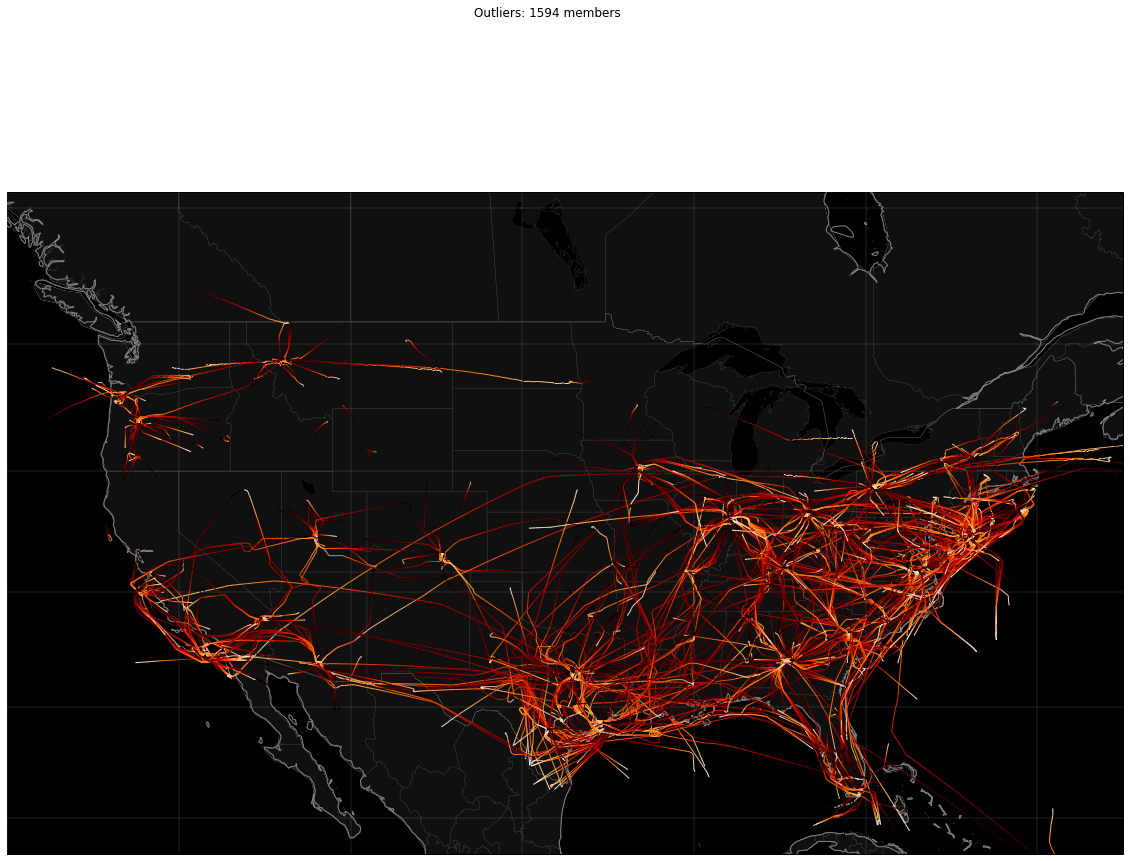

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d1c50f8> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d1c50f8> >


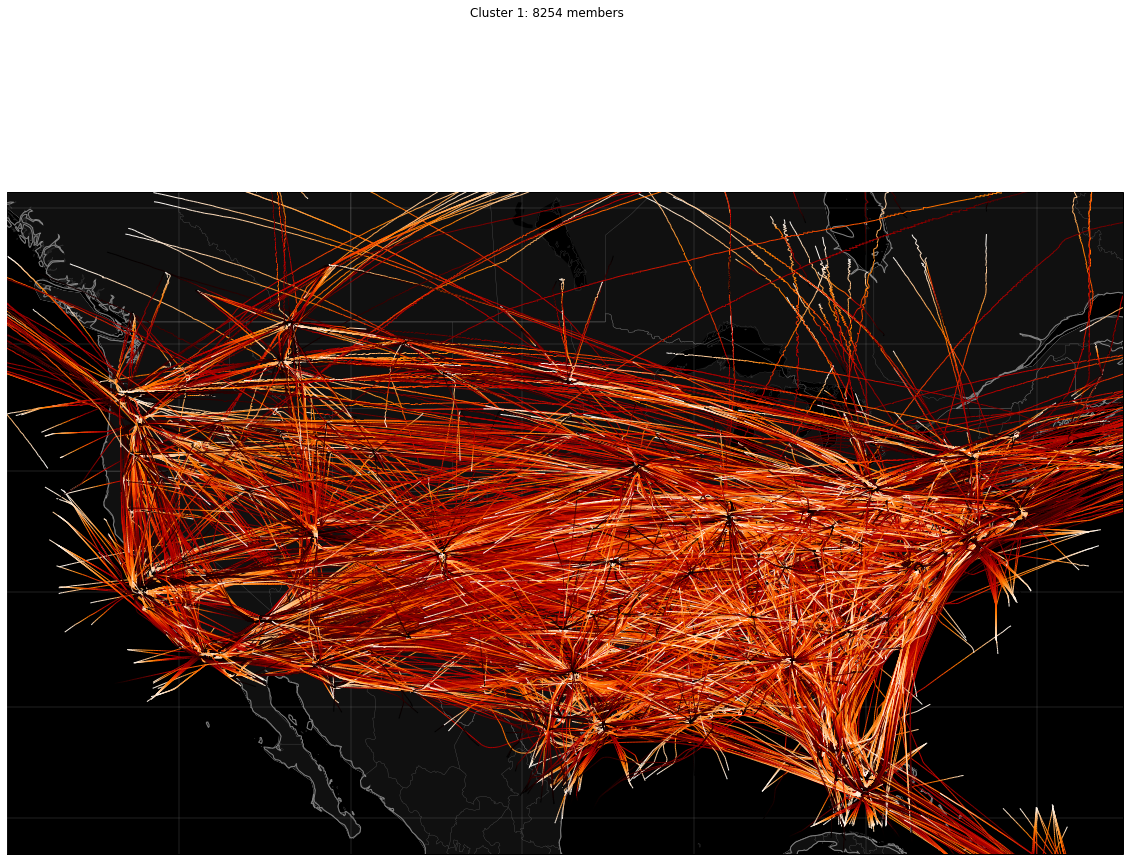

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d1c52b0> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d1c52b0> >


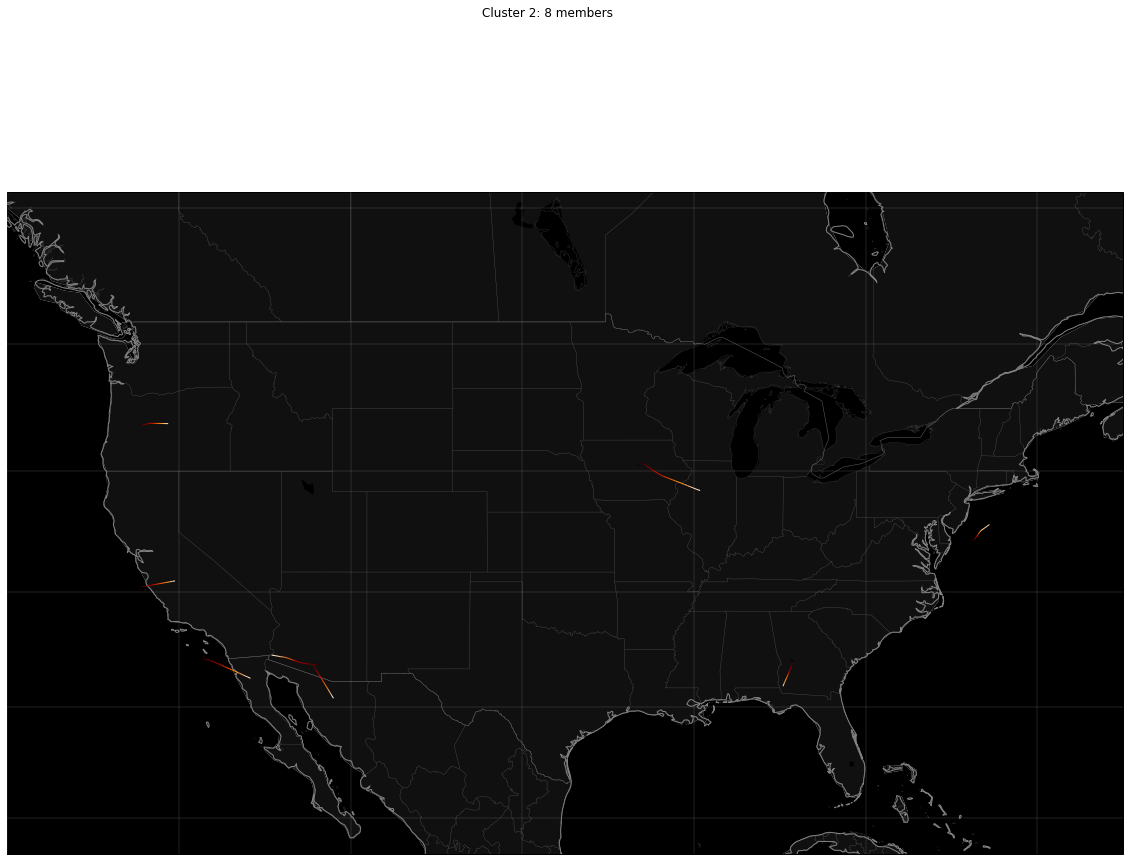

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d1c5e60> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d1c5e60> >


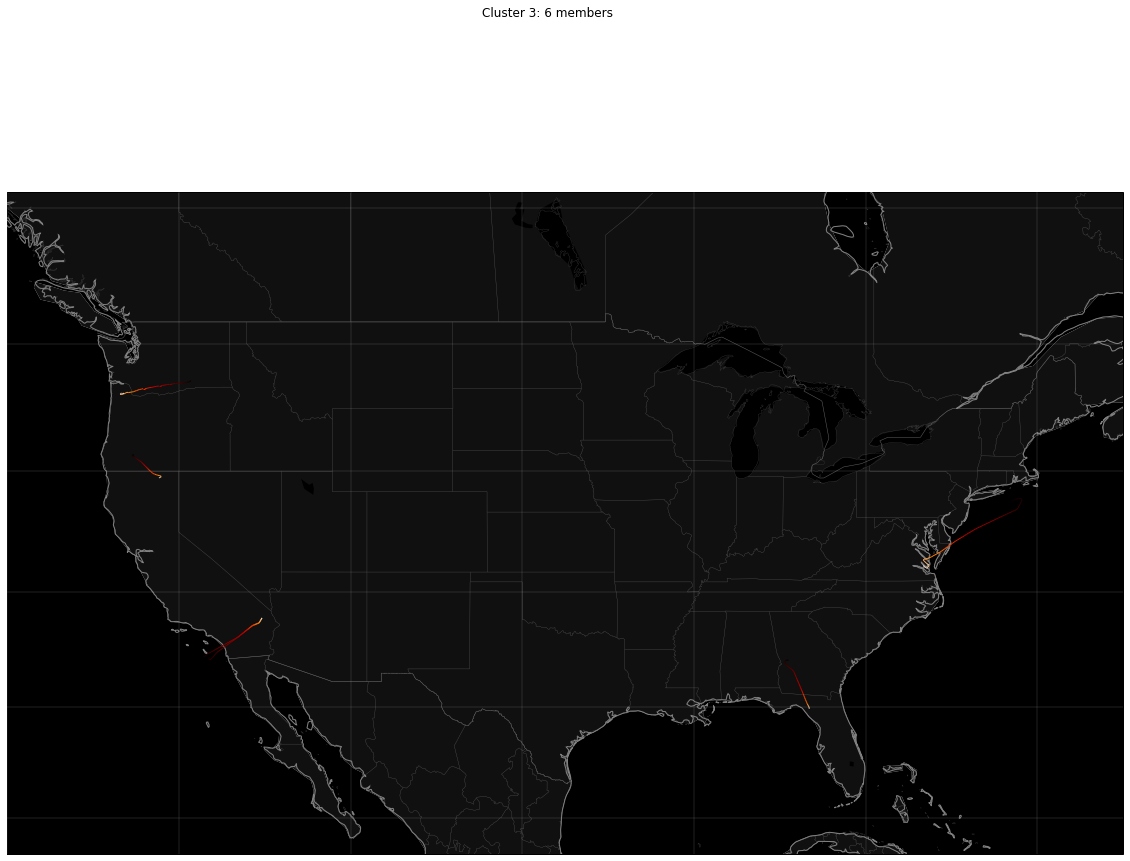

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d1c53b8> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d1c53b8> >


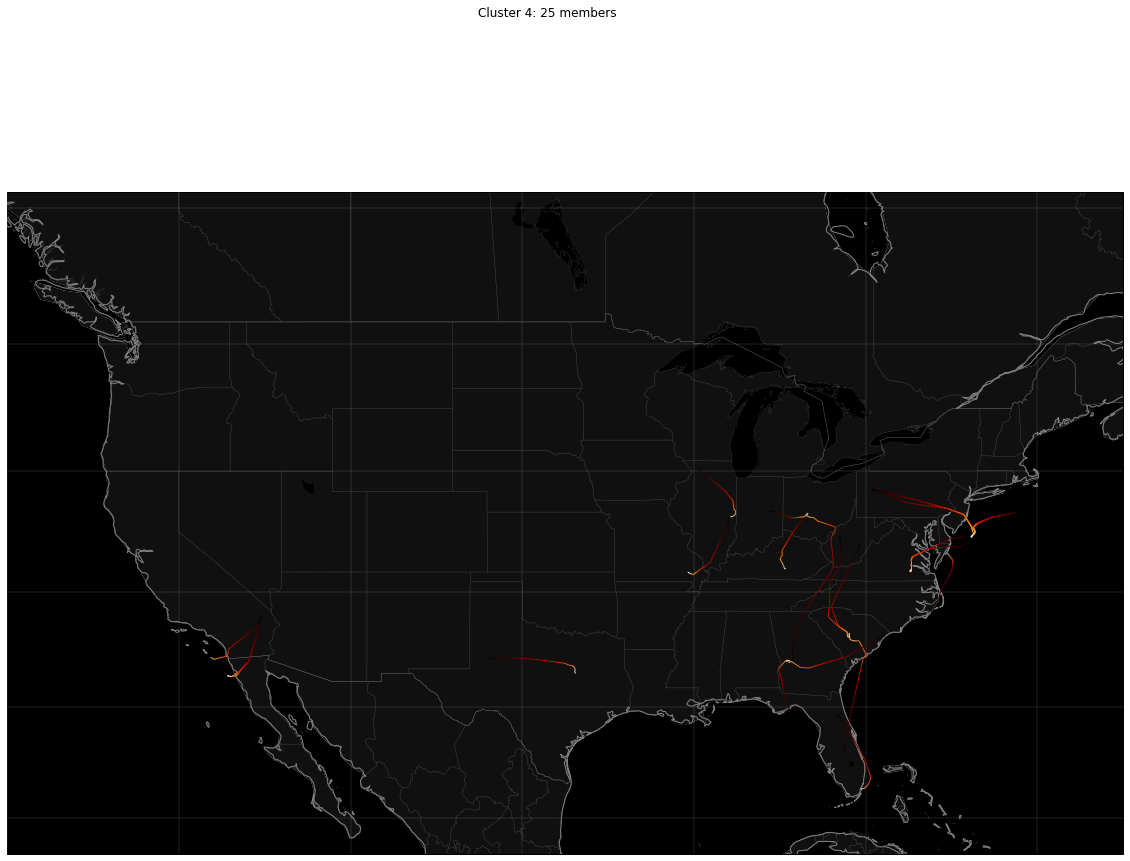

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d059bf8> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d059bf8> >


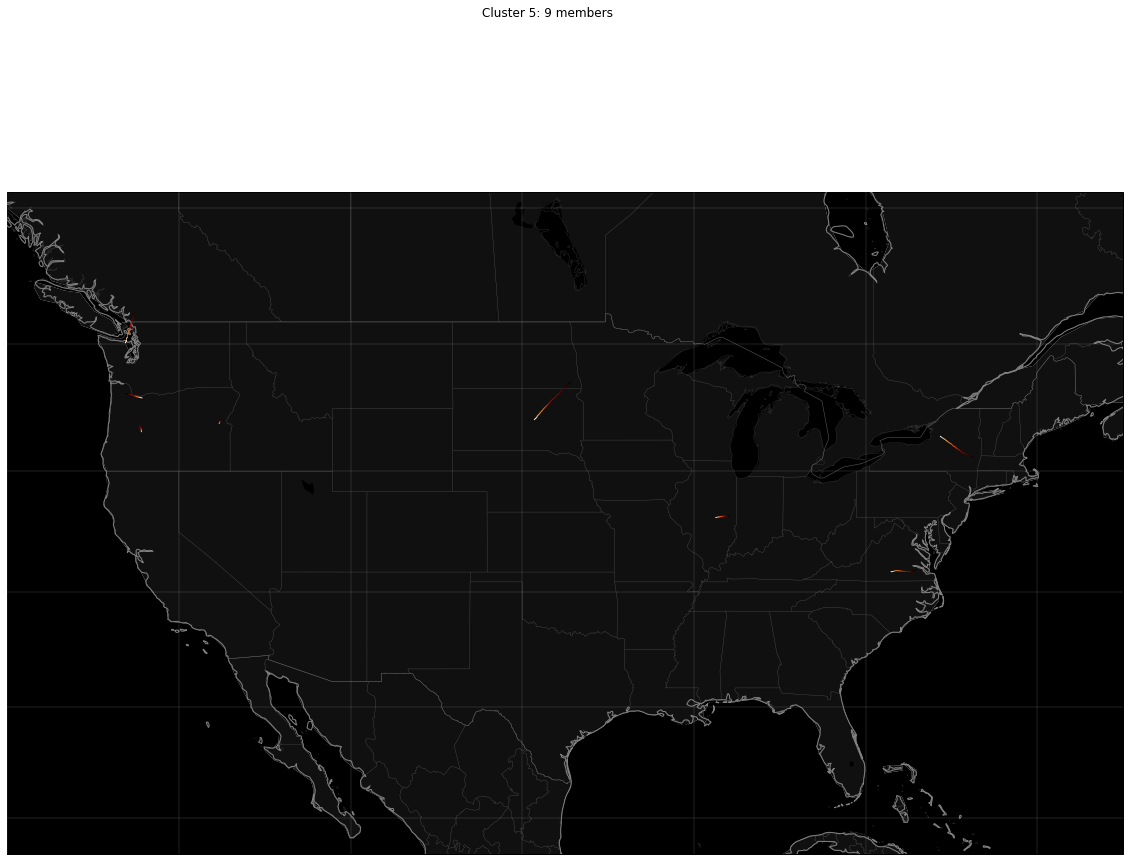

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d0595c8> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d0595c8> >


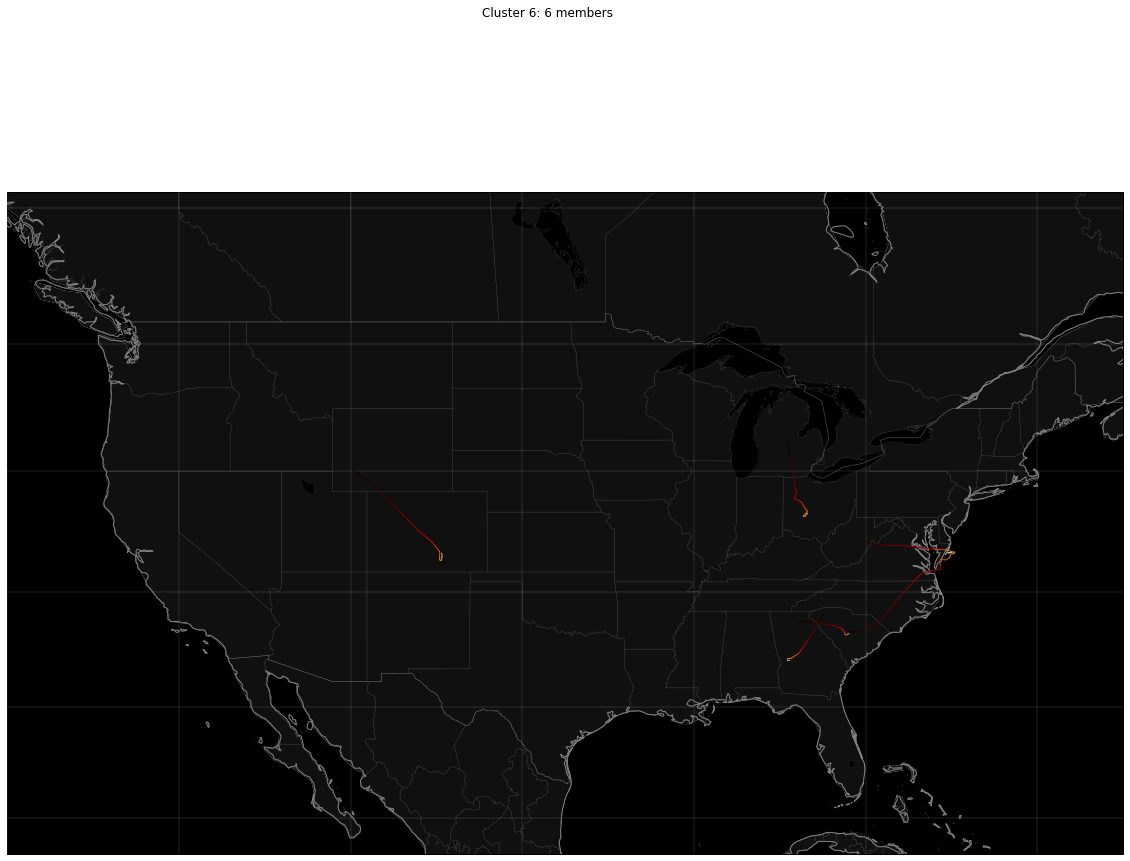

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d059518> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x12d059518> >


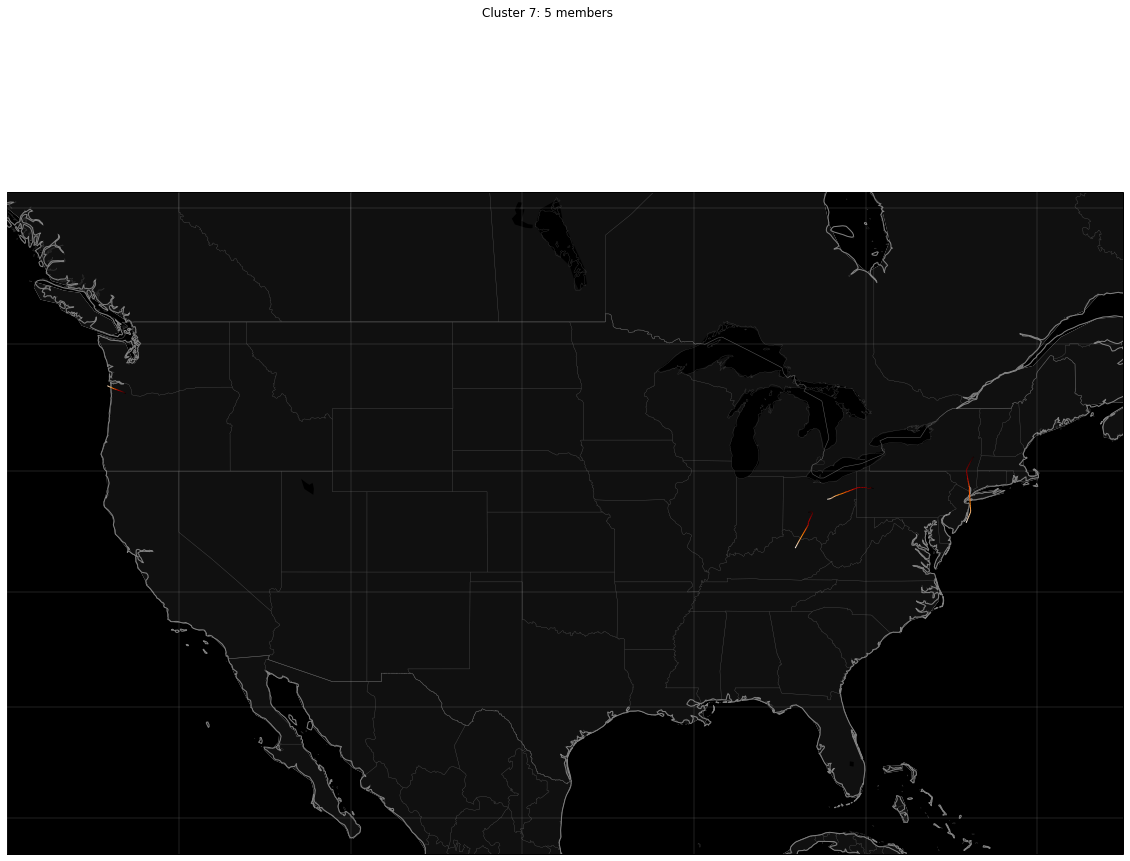

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x127badbf8> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x127badbf8> >


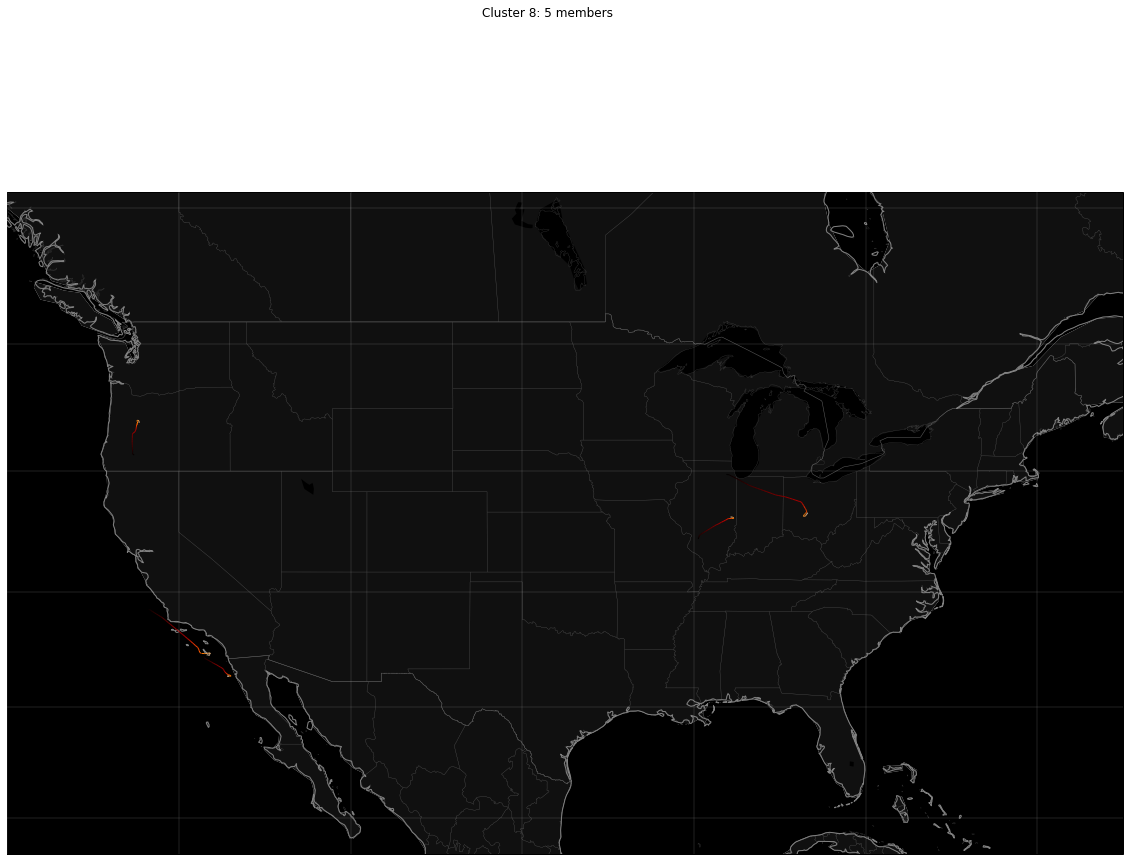

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x127bad9e8> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x127bad9e8> >


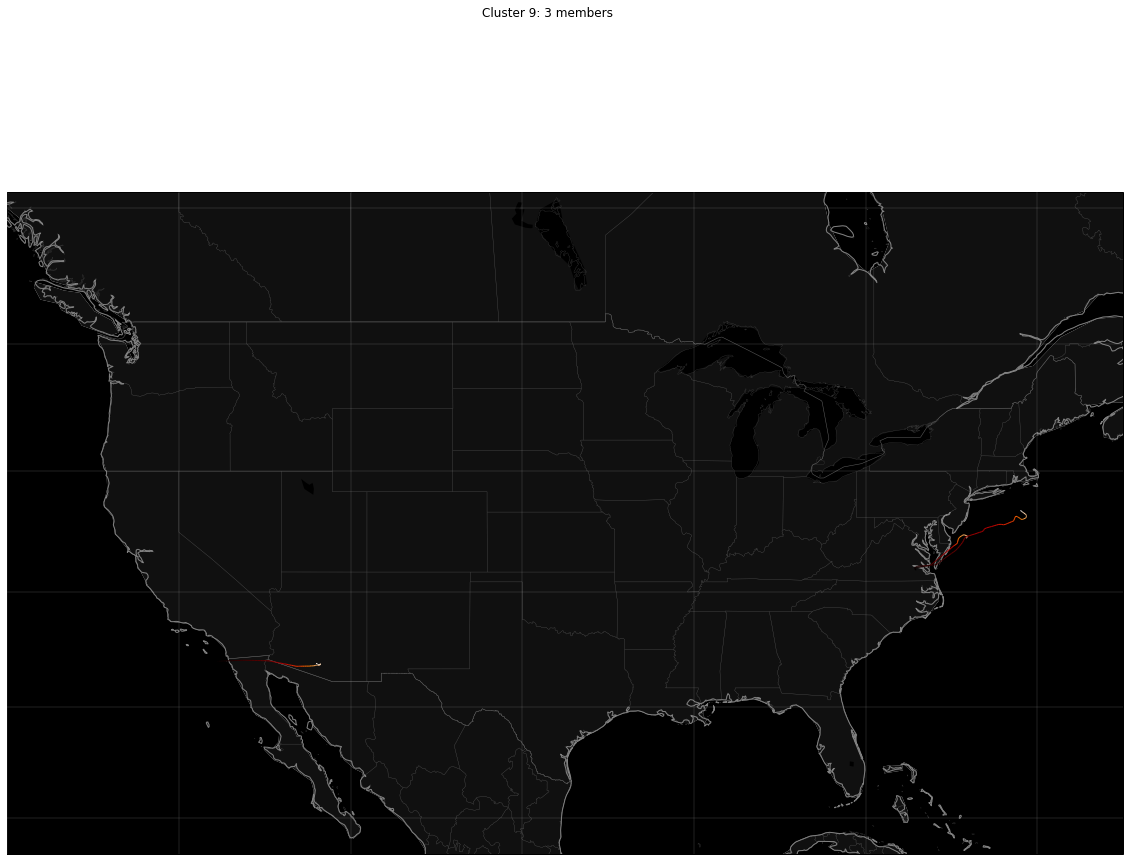

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x1282f6d58> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x1282f6d58> >


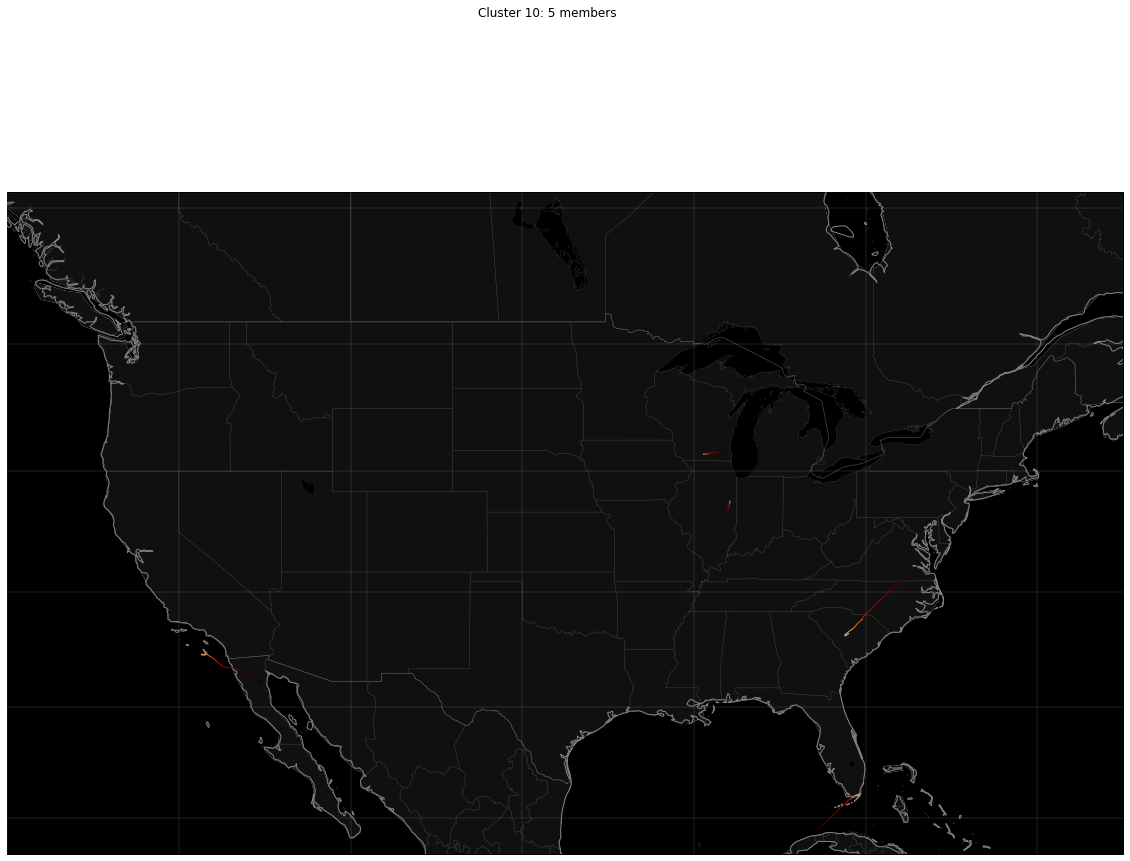

DEBUG: region_map: projection is <class 'cartopy.crs.Miller'>
DEBUG: Map projection is <class 'cartopy.crs.Miller'>, type <class 'abc.ABCMeta'>
DEBUG: map successfully instantiated
DEBUG: axes are < GeoAxes: <cartopy.crs.Miller object at 0x1282f6b48> >
DEBUG: region_map: map_axes are < GeoAxes: <cartopy.crs.Miller object at 0x1282f6b48> >


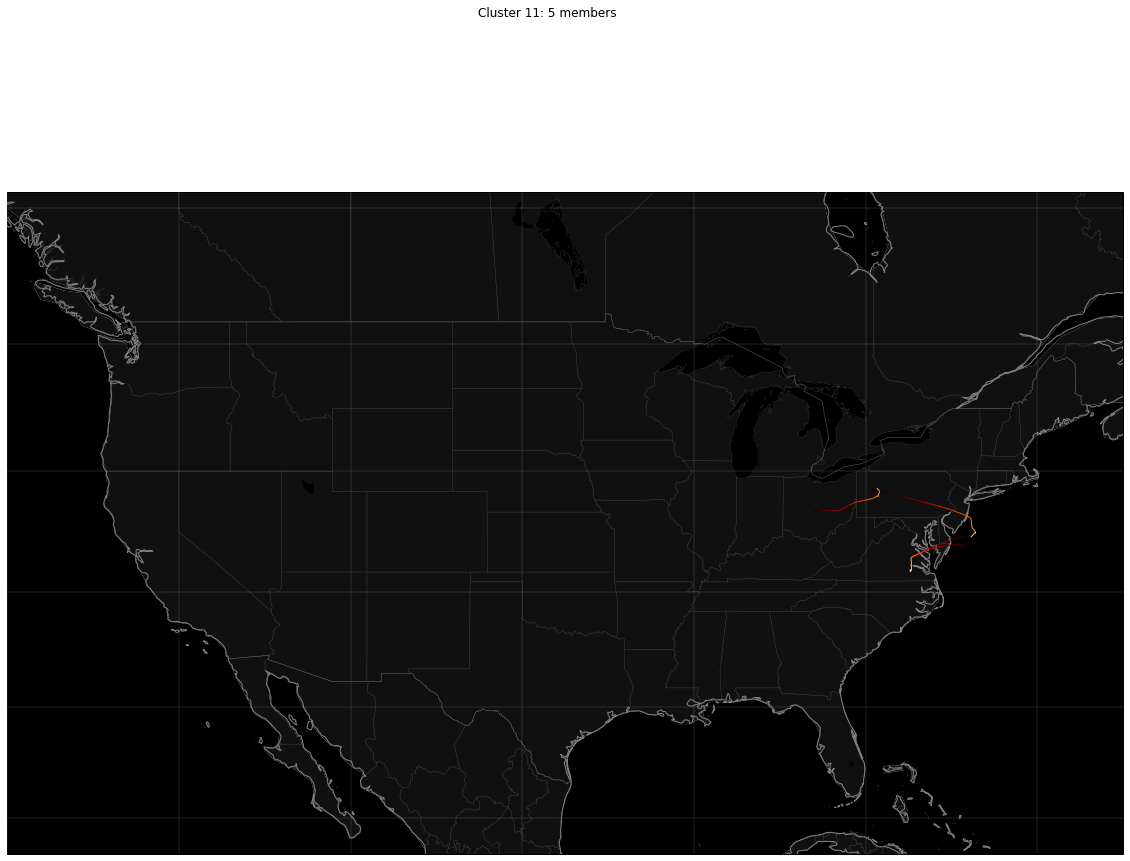

In [7]:
from tracktable.examples.trajectory_map_from_points import initialize_matplotlib_figure
from tracktable.examples.example_trajectory_rendering import render_trajectories
from tracktable.domain import terrestrial
from tracktable.render import mapmaker
from matplotlib import pyplot

sorted_ids = sorted(clusters.keys())

for cluster_id in sorted_ids:
    # Set up the canvas and map projection
    figure = pyplot.figure(figsize=[20, 15])
    axes = figure.add_subplot(1, 1, 1)
    #(figure, axes) = initialize_matplotlib_figure([10, 7.5])
    (mymap, map_actors) = mapmaker.mapmaker(domain='terrestrial',
                                            map_name='region:conus')

    render_trajectories(mymap, clusters[cluster_id], trajectory_linewidth=1)
    figure.suptitle('{}: {} members'.format(
       cluster_name(cluster_id),
       len(clusters[cluster_id])))
    pyplot.show()